In [3]:
using LinearAlgebra, Plots, Random, Distributions, NLsolve, Plots

First, let us create a NamedTuple with our parameters.

In [4]:
params = (; β = 0.72, # bargaining_power
            r = 0.012, # discount rate
            λ = 4, # arrival rate
            z = 0.4, # value of leisure
            p_star = 1., # productivity
            s_star = 0.1, # separation rate
            c = 0.213, # cost of vacancy
            σ = 0.0165, # standard deviation 
            γ = 0.004, # autoregressive coefficient
            n = 2001, # gridpoints
            lb = -1., # bounds for grid
            ub = 1., # bounds for grid
            μ = 1.355, # constant term in matching function
            me = -0.72, # exponent in matching function
            max_iter  = 1000, # maximum number of iterations
            agents = 10000, # number of agents
            periods = 1213, # number of periods
            seed1 = 10, # seed1 for random number generator
            seed2 = 4, # seed2 for random number generator
            seed3 = 11 ) # seed3 for random number generator 

(β = 0.72, r = 0.012, λ = 4, z = 0.4, p_star = 1.0, s_star = 0.1, c = 0.213, σ = 0.0165, γ = 0.004, n = 2001, lb = -1.0, ub = 1.0, μ = 1.355, me = -0.72, max_iter = 1000, agents = 10000, periods = 1213, seed1 = 10, seed2 = 4, seed3 = 11)

In [5]:
function matching_function(grid, params)
    (; μ, me) = params
    return μ .* (grid .^ me)
end

matching_function (generic function with 1 method)

In [6]:
function generate_income_process(params)
    (; n, lb, ub) = params
    Δ = ub / n
    grid = LinRange(lb, ub, n)
    exp_grid = exp.(grid)
    transition_matrix = zeros(n, n)
    for i in 1:n
        if i == 1
            transition_matrix[i, i] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i+1] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        elseif i == n
            transition_matrix[i, i-1] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        else
            transition_matrix[i, i-1] = ( 1/2 ) * (1 .+ (grid[i] / (n*Δ)))
            transition_matrix[i, i+1] = ( 1/2 ) * (1 .- (grid[i] / (n*Δ)))
        end
    end
    return exp_grid, transition_matrix
end

income_process, transition_matrix = generate_income_process(params)

([0.36787944117144233, 0.3682475046136629, 0.3686159363034188, 0.3689847366091417, 0.369353905899632, 0.3697234445440589, 0.3700933529119613, 0.37046363137324734, 0.37083428029819565, 0.37120530005745517  …  2.6939270528874992, 2.696622327353013, 2.6993202984410796, 2.7020209688496686, 2.7047243412794524, 2.7074304184338023, 2.7101392030187967, 2.7128506977432196, 2.715564905318567, 2.718281828459045], [0.0 1.0 … 0.0 0.0; 0.0004999999999999449 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0004999999999999449; 0.0 0.0 … 1.0 0.0])

In [7]:
function productivity_grid(params)
    (; z, p_star) = params
    grid = generate_income_process(params)
    p_grid = z .+ (grid[1] .* (p_star - z))
    return p_grid
end

function separation_grid(params)
    (; n, s_star) = params
    grid = generate_income_process(params)
    s_grid = grid[1] .* s_star
    return s_grid
end

function theta_grid(params)
    (; n) = params
    grid = generate_income_process(params)
    θ_grid = LinRange(0.1,3,n)
    return θ_grid
end

theta_grid (generic function with 1 method)

In [12]:
function bargaining_grid(params)
    (; n) = params
    lower_bound = 0.64
    upper_bound = 0.80
    grid = LinRange(lower_bound, upper_bound, n)    
    return reverse(grid)
end

barg_grid = bargaining_grid(params)

2001-element LinRange{Float64, Int64}:
 0.8, 0.79992, 0.79984, 0.79976, 0.79968, …, 0.64024, 0.64016, 0.64008, 0.64

In [11]:
function iterate_prod_barg(grid, params)
    (; r, λ, z, p_star, s_star, c, σ, γ, n, lb, ub, mc, me, max_iter) = params
    Δ = ub / n
    exp_grid, transition_matrix = generate_income_process(params)
    prod_grid = productivity_grid(params)
    β = bargaining_grid(params)
    iter = 0
    error = Inf
    new_grid = zeros(n)
    while iter < max_iter && error > 0.001
        iter += 1
        match_grid = matching_function(grid, params)
        for i in 1:n
            if i == 1
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            elseif i == n
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1])), [grid[i]])
                new_grid[i] = result.zero[1]
            else
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β[i])*(prod_grid[i]-z)) / c ) - β[i]*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1]) + (transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            end
        end
        error = norm(new_grid - grid)
        grid = copy(new_grid)
        if iter % 1 == 0
            println("Iteration: $iter, Error: $error")
        end
    end
    return grid
end

θ_grid = theta_grid(params)
thetas_barg = iterate_prod_barg(θ_grid, params)

Iteration: 1, Error: 20.095365965672737
Iteration: 2, Error: 1.5756105466694514
Iteration: 3, Error: 0.13157801754922868
Iteration: 4, Error: 0.01142946280340591
Iteration: 5, Error: 0.0010867025345807162
Iteration: 6, Error: 0.00012097652090862869


2001-element Vector{Float64}:
 0.22514867331977384
 0.22549511191916263
 0.22584201765365652
 0.2261894348516834
 0.2265373416182277
 0.22688574386916102
 0.2272346394659428
 0.2275840402300056
 0.22793393091317585
 0.22828432428018341
 ⋮
 3.904921692787293
 3.9102604083157284
 3.9156063117875815
 3.920959357162226
 3.9263195420176134
 3.9316869376197885
 3.937061459077796
 3.942443251550919
 3.9478321392164313

In [8]:
function generate_poisson_matrix(params)
    (;periods, agents, λ) = params
    dist = Poisson(λ)
    matrix = rand(dist, 1, periods)
    matrix[matrix .!= λ] .= 0.0
    matrix[matrix .!= 0.0] .= 1.0
    transition_matrix = zeros(1, periods)
    Random.seed!(params.seed2)
    dist2 = Uniform(0,1)
    transitions = rand(dist2, 1, periods)
    return matrix, transitions
end

arrival_matrix, transitions = generate_poisson_matrix(params)
display(arrival_matrix)

1×1213 Matrix{Int64}:
 0  0  0  0  0  0  0  0  1  1  1  0  0  …  0  0  0  0  0  0  1  0  0  1  0  1

In [9]:
function generate_sep_matrix(params)
    (;agents, periods, seed1) = params
    Random.seed!(seed1)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents, periods)
    matrix[matrix .> 0.1] .= 0.0
    matrix[matrix .!= 0.0] .= 1.0
    return matrix
end

sep_matrix = generate_sep_matrix(params)

10000×1213 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     1.0  0.0  1.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱                      ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
function generate_matching_matrix(params)
    (;agents, periods, seed2) = params
    Random.seed!(seed2)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents, periods)
    return matrix
end

match_matrix = generate_matching_matrix(params)

10000×1213 Matrix{Float64}:
 0.64056    0.780026   0.615713   …  0.981091  0.746891   0.925536
 0.324442   0.861464   0.507289      0.895722  0.251462   0.0015065
 0.428415   0.274646   0.508303      0.911043  0.181553   0.438091
 0.353998   0.504371   0.746542      0.470011  0.520421   0.152647
 0.624069   0.958314   0.964312      0.614595  0.778817   0.224829
 0.609341   0.926286   0.549811   …  0.85397   0.0971608  0.700282
 0.814895   0.682179   0.969977      0.974736  0.10915    0.0661041
 0.858176   0.426651   0.6334        0.352351  0.131948   0.143058
 0.403735   0.905022   0.75598       0.329795  0.359055   0.635839
 0.0465632  0.0466358  0.330353      0.322006  0.96039    0.774086
 ⋮                                ⋱  ⋮                    
 0.483252   0.985512   0.456219      0.141671  0.524543   0.349105
 0.0409949  0.319155   0.154516      0.584434  0.744197   0.290747
 0.277812   0.522861   0.0928757     0.614265  0.1321     0.556807
 0.416269   0.958241   0.914777      0.9

In [11]:
function optim_theta(grid, params)
    (; β, r, λ, z, p_star, s_star, c, σ, γ, n, lb, ub, μ, me, max_iter) = params
    Δ = ub / n
    exp_grid, transition_matrix = generate_income_process(params)
    prod_grid = productivity_grid(params)
    iter = 0
    error = Inf
    new_grid = zeros(n)
    while iter < max_iter && error > 0.001
        iter += 1
        match_grid = matching_function(grid, params)
        for i in 1:n
            if i == 1
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            elseif i == n
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1])), [grid[i]])
                new_grid[i] = result.zero[1]
            else
                result = nlsolve(theta -> - ((r+s_star+λ) / match_grid[i]) + (((1-β)*(prod_grid[i]-z)) / c ) - β*theta[1] + λ*((transition_matrix[i, i-1] / match_grid[i-1]) + (transition_matrix[i, i+1] / match_grid[i+1])), [grid[i]])
                new_grid[i] = result.zero[1]
            end
        end
        error = norm(new_grid - grid)
        grid = copy(new_grid)
        if iter % 1 == 0
            println("Iteration: $iter, Error: $error")
        end
    end
    find_probs = matching_function(grid, params).*grid
    find_probs = find_probs ./ maximum(find_probs)
    return grid, find_probs
end

θ_grid = theta_grid(params)
probs_find = optim_theta(θ_grid, params)[2]

Iteration: 1, Error: 22.24042821451652
Iteration: 2, Error: 1.645337822710512
Iteration: 3, Error: 0.13490677881814264
Iteration: 4, Error: 0.012028792790704025
Iteration: 5, Error: 0.0012228452433972544
Iteration: 6, Error: 0.00014429373642639175


2001-element Vector{Float64}:
 0.5625584887286226
 0.562721438395461
 0.562884415492137
 0.5630474623743051
 0.563210532922636
 0.5633736592481231
 0.563536832075869
 0.5637000371424581
 0.5638633060063852
 0.5640266064640209
 ⋮
 0.9977149343715417
 0.9980002871043534
 0.998285720187221
 0.9985712318225917
 0.9988568263599019
 0.9991424988143064
 0.9994282524091771
 0.9997140871828105
 1.0

In [12]:
function initial_u(params)
    (; agents) = params
    Random.seed!(10)
    u_init = randn(1)
    dist = Uniform(0., 1.)
    matrix = rand(dist, agents)
    matrix[matrix .> u_init] .= 1
    matrix[matrix .!= 1] .= 0
    return matrix
end

u_init = initial_u(params)

10000-element Vector{Float64}:
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 1.0
 1.0
 ⋮
 0.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 0.0
 0.0

In [13]:
function simulation(params)
    (; agents, periods, n) = params

    p_grid = productivity_grid(params)
    s_grid = separation_grid(params)
    
    p_init = p_grid[10]
    
    agg_prod, agg_transitions = generate_poisson_matrix(params)
    income_process, transitions = generate_income_process(params)
    
    index = findfirst(isequal(p_init), p_grid)
    
    initial_θ = θ_grid[index]
    
    employment_sim = zeros(agents , periods) 
    employment_sim[:,1] .= u_init .== 0.0
    
    sim_p = zeros(1, periods)
    sim_p[:,1] .= p_init
    
    sim_θ = zeros(1, periods)
    sim_θ[:,1] .= initial_θ
    
    sim_f = zeros(1, periods) # θ*q(θ)
    sim_f[:,1] .= sim_θ[:,1] .* matching_function(sim_θ[:,1], params)
    
    sim_u = zeros(1, periods)
    fraction = mean(u_init .== 1.0)
    sim_u[:,1] .= fraction
    
    sim_v = zeros(1, periods)
    sim_v[:,1] .= sim_u[:,1] .* sim_θ[:,1] 
    
    thetas, probs_find = optim_theta(θ_grid, params)
    match_matrix = generate_matching_matrix(params)
    sep_matrix = generate_sep_matrix(params)
    
    for i in 1:agents
        for j in 1:periods
            index = findfirst(isequal(sim_p[1,j]), p_grid)
            if agg_prod[1,j] == 1.0
                if agg_transitions[1,j] <= transitions[index,index-1]
                    if index == 1
                        sim_p[1,j] = p_grid[index]
                        sim_p[1,j+1] = p_grid[index]
                        sim_θ[1,j] = thetas[index]
                        sim_θ[1,j+1] = thetas[index]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params)) / maximum((sim_θ[1,j] * matching_function(sim_θ[1,j], params)))
                        sim_f[1,j+1] = sim_f[1,j]                  
                    else
                        sim_p[1,j] = p_grid[index-1]
                        sim_θ[1,j] = thetas[index-1]
                        sim_f[1,j] = (sim_θ[1,j] * matching_function(sim_θ[1,j], params)) / maximum((sim_θ[1,j] * matching_function(sim_θ[1,j], params)))
                        sim_p[1,j+1] = p_grid[index-1]
                        sim_θ[1,j+1] = thetas[index-1]
                        sim_f[1,j+1] = sim_f[1,j]  
                    end
                elseif index < n
                    index2 = index + 1
                    sim_p[1,j+1] = p_grid[index2]
                    sim_θ[1,j+1] = thetas[index2]
                    sim_f[1,j+1] = sim_f[1,j]
                elseif index == n
                    sim_p[1,j+1] = p_grid[index]
                    sim_θ[1,j+1] = thetas[index]
                    sim_f[1,j+1] = sim_f[1,j]
                end
            elseif j < periods 
                sim_p[1,j+1] = sim_p[1,j]
                sim_θ[1,j+1] = sim_θ[1,j]
                sim_f[1,j+1] = sim_f[1,j]   
            end
            if employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 0.0 && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 1.0 && sep_matrix[i,j] == 1.0 && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if employment_sim[i,j] == 0.0 && match_matrix[i,j] <= probs_find[index] && j < periods
                employment_sim[i,j+1] = 1.0
            elseif employment_sim[i,j] == 0.0 && match_matrix[i,j] > probs_find[index] && j < periods
                employment_sim[i,j+1] = 0.0
            end
            if j < periods
                sim_u[1,j+1] = mean(employment_sim[i,j+1] .== 1.0)
                sim_v[1,j+1] = sim_u[1,j+1] .* sim_θ[1,j+1]
            end
            if i % 1000 == 0 && j == 1213
                println("completed agent $i")
            end
        end
    end
    return sim_u, sim_v, sim_p, sim_θ, sim_f
end

sim_u, sim_v, sim_p, sim_θ, sim_f = simulation(params)

Iteration: 1, Error: 22.24042821451652
Iteration: 2, Error: 1.645337822710512
Iteration: 3, Error: 0.13490677881814264
Iteration: 4, Error: 0.012028792790704025
Iteration: 5, Error: 0.0012228452433972544
Iteration: 6, Error: 0.00014429373642639175
completed agent 1000
completed agent 2000
completed agent 3000
completed agent 4000
completed agent 5000
completed agent 6000
completed agent 7000
completed agent 8000
completed agent 9000
completed agent 10000


([0.6595 1.0 … 0.0 0.0], [0.07455647500000001 0.11305000000000001 … 0.0 0.0], [0.6227231800344731 0.6227231800344731 … 0.6728520359007641 0.6731250244081696], [0.11305000000000001 0.11305000000000001 … 0.43630477168920406 0.43675550703984156], [0.7359614288056299 0.7359614288056299 … 1.0 1.0])

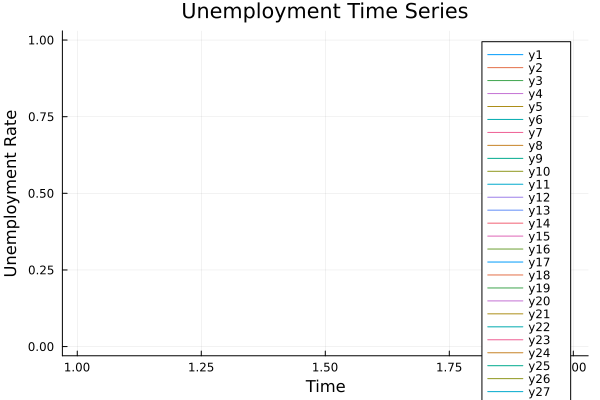

In [14]:
using Plotsccccccccccccccccccx = range(1, stop=212, length=length(sim_u))
plot(sim_u, title = "Unemployment Time Series", xlabel = "Time", ylabel = "Unemployment Rate")
